# Supervised Classification with Deep Learning for Sentinel-2 Satellite Imagery

Michael Mommert, Stuttgart University of Applied Sciences, 2024

This Notebook introduces the workflow for supervised learning with Neural Networks. We will apply these methods to Sentinel-2 satellite images from the [*ben-ge-800* dataset](https://zenodo.org/records/12941231) to perform pixel-wise classification based on land-use/land-cover data from the [ESAWorldCover dataset](https://esa-worldcover.org/en). 

In [ ]:
! pip install -r requirements.txt

  Obtaining dependency information for ipympl from https://files.pythonhosted.org/packages/d8/50/d6f4e7eb0e7d198b431d8259bc9a6035f879d4df487448b196cdf1e84155/ipympl-0.9.4-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 710.2 kB/s eta 0:00:00 kB/s eta 0:00:01:01


## Content

1. [Setting up the environment and data download](#setup)
2. [Data Inspection](#data_inspection)
3. [Data Handling](#data)
4. [Model Implementation](#model)
5. [Training and Validation Pipeline](#train-val)
6. [Hyperparameter Tuning](#hyperpars)
7. [Evaluation](#evaluation)
8. [Inference](#inference)


<a id='setup'></a>
## 1. Setup and Data Download

We're setting up our Python environment for this tutorial by installing and importing the necessary modules and packages:

In [1]:
# system level modules for handling files and file structures
import os
import tarfile
import copy

# scipy ecosystem imports for numerics, data handling and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# pytorch and helper modules
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchmetrics import Accuracy

# utils
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# rasterio for reading in satellite image data
import rasterio as rio


We download the *ben-ge-800* dataset and unpack it:

In [3]:
!wget https://zenodo.org/records/12941231/files/ben-ge-800.tar.gz?download=1 -O ben-ge-800.tar.gz
  
tarfile = tarfile.open('ben-ge-800.tar.gz')  # open ben-ge-800 tarball 
tarfile.extractall('./')  # extract tarball

data_base_path = os.path.join(os.path.abspath('.'), 'ben-ge-800')

--2024-08-24 17:51:42--  https://zenodo.org/records/12941231/files/ben-ge-800.tar.gz?download=1
Resolving zenodo.org (zenodo.org)... 188.185.79.172, 188.184.103.159, 188.184.98.238, ...
Connecting to zenodo.org (zenodo.org)|188.185.79.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 183201083 (175M) [application/octet-stream]
Saving to: ‘ben-ge-800.tar.gz’

ben-ge-800.tar.gz     0%[                    ] 683,12K  53,1KB/s    eta 53m 18s^C


EOFError: Compressed file ended before the end-of-stream marker was reached

**ben-ge-800** contains samples for 800 locations with co-located Sentinel-1 SAR data, Sentinel-2 multispectral data, elevation data, land-use/land-cover data, as well as environmental data. **ben-ge-800** is a subset of the much larger **ben-ge** dataset (see [https://github.com/HSG-AIML/ben-ge](https://github.com/HSG-AIML/ben-ge) for details.) We deliberately use a very small subset of **ben-ge** to enable reasonable runtimes for the examples shown in this tutorial.

The environment is now set up and the data in place. Before we define the dataset classes and dataloaders to access the data efficiently, we fix some random seeds to obtain reproduceable results:

In [15]:
np.random.seed(42)     # sets the seed value in Numpy
torch.manual_seed(42)  # sets the seed value in Pytorch

<a id='data_inspection'></a>
## 2. Data Inspection

Before we start implementing our model, let's have a look at the data. In this notebook, we need two different data products that are available for every single sample in the dataset:
* Sentinel-2 multispectral data: 12-band Level-2A images of size 120x120; we will restrict ourselves to the 4 bands that carry 10m-resolution imaging data (bands 2, 3, 4 and 8)
* [ESAWorldCover](https://esa-worldcover.org/en) land-use/land-cover labels: for each pixel of each image, a class label is provided that corresponds to one of 11 different classes.

Let's have a look at how to access the different data products:

### Sentinel-2

Sentinel-2 data are located in the `ben-ge-800/sentinel-2/` directory. Each sample has its own subdirectory; random sample is named `S2B_MSIL2A_20170814T100029_90_11`. For each sample, 12 `.tif` files are available, one for each band. Let's open the red band data for this sample:

In [16]:
dataset = rio.open("ben-ge-800/sentinel-2/S2B_MSIL2A_20170814T100029_90_11/S2B_MSIL2A_20170814T100029_90_11_B04.tif")  # open tif file with rasterio
data = dataset.read(1)  # read data (band 1, since there is only one band)
data.shape, data.dtype

((120, 120), dtype('uint16'))

The data has indeed the shape 120x120 pixels (per band) and the data is stored as 16-bit integer values. Let's plot the data as a greyscale image:

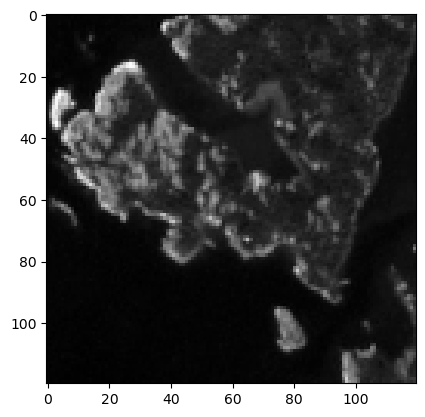

In [17]:
plt.imshow((data-np.min(data))/(np.max(data)-np.min(data)), cmap='Greys_r')

To plot a color image, we have to also open and read the blue and green bands. This is straightforward, since R, G, and B have the same spatial resolutions. Most other bands, however, have different spatial resolutions. Therefore, we have to resample the data to 10m resolution. Let's do this for all bands and then plot the true color information:

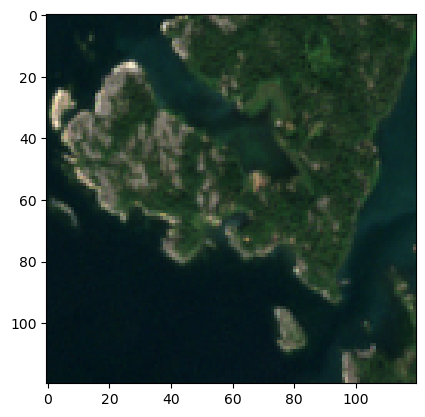

In [18]:
# an ordered list of all the bands to be extracted
s2_bands = [2, 3, 4, 8]  # B, G, R, NIR

# read all bands for one sample
img = np.empty((4, 120, 120))
for i, band in enumerate(s2_bands):

    # read corresponding data file and upsample based on resampling factor
    with rio.open(f"ben-ge-800/sentinel-2/S2B_MSIL2A_20170814T100029_90_11/S2B_MSIL2A_20170814T100029_90_11_B0{band}.tif") as dataset:
                data = dataset.read()
    img[i,:,:] = data

# plot the RGB information for that sample
img_rgb = np.dstack(img[0:3][::-1])  # extract RGB, reorder, and perform a deep stack (shape: 120, 120, 3)
plt.imshow((img_rgb-np.min(img_rgb))/(np.max(img_rgb)-np.min(img_rgb)))

In order to normalize our Sentinel-2 data, we simply divide the pixel values in each band by 10000 and clip the range from 0 to 1. This provides a reasonable value in each band:

In [249]:
np.average(np.clip(img/10000, 0, 1), axis=(1,2))

array([0.0301817 , 0.03595887, 0.02285837, 0.11646207])

### Land-use/land-cover data

Finally, we will read in the ESAWorldCover land-use/land-cover data. Since the lulc data form a map with the same size as the image, the data is stored as a TIF file, just like the image data. Let's open the lulc data file that corresponds to the scene shown above:

In [20]:
with rio.open("ben-ge-800/esaworldcover/S2B_MSIL2A_20170814T100029_90_11_esaworldcover.tif") as d:
    ewc_data = d.read(1)

ewc_data

array([[80, 80, 80, ..., 10, 10, 10],
       [80, 80, 80, ..., 10, 10, 10],
       [80, 80, 80, ..., 10, 10, 10],
       ...,
       [80, 80, 80, ..., 30, 30, 10],
       [80, 80, 80, ..., 30, 30, 10],
       [80, 80, 80, ..., 30, 30, 10]], dtype=int8)

The class labels are encoded in numerical codes. Before we continue, we define a colormap for displaying the lulc data in a visually appealing way and we define the class label names for better understanding:

In [21]:
# define ESA WorldCover colormap
COLOR_CATEGORIES = [
    (0, 100, 0),
    (255, 187, 34),
    (255, 255, 76),
    (240, 150, 255),
    (250, 0, 0),
    (180, 180, 180),
    (240, 240, 240),
    (0, 100, 200),
    (0, 150, 160),
    (0, 207, 117),
    (250, 230, 160)]
cmap_all = mpl.colors.ListedColormap(np.array(COLOR_CATEGORIES)/255.)

# class label names
ewc_label_names = ["tree_cover", "shrubland", "grassland", "cropland", "built-up",
                   "bare/sparse_vegetation", "snow_and_ice","permanent_water_bodies",
                   "herbaceous_wetland", "mangroves","moss_and_lichen"]


Now we turn the numerical codes into a continuous range of integer values; the order corresponds to the order used in the color map and the class label name list:

In [22]:
ewc_mask = ewc_data.astype(float)   
ewc_mask[ewc_mask == 100] = 110  # fix some irregular class labels
ewc_mask[ewc_mask == 95] = 100   # fix some irregular class labels
ewc_mask = ewc_mask / 10 - 1 # transform to scale [0, 11]

Finally, we can plot the lulc map next to the satellite image:

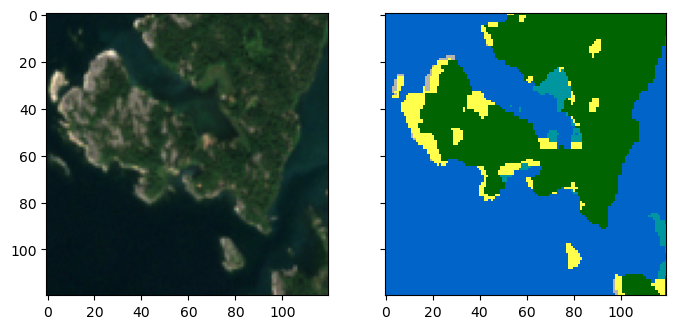

In [23]:
f, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8,4))

ax[0].imshow((img_rgb-np.min(img_rgb))/(np.max(img_rgb)-np.min(img_rgb)))
ax[1].imshow(ewc_mask, cmap=cmap_all, vmin=0, vmax=11, interpolation='nearest')

<a id='data'></a>
## 3. Data Handling

In the following, we implement a dataset class that combines the data access methods introduced above for the two data modalities. The dataset class provides easy and homogeneous access to the data on a per-sample basis. As part of the dataset class, we apply data normalizations and output all numeric features as *Pytorch* tensors; tensors are the Pytorch equivalent of Numpy arrays but tensors can use GPU infrastructure for more efficient computations. Finally, we use predefined dataset splits: we can generate a training, validation and test dataset.

Also note that, unlike semantic segmentation, we will set this problem us as a classification problem, which means that each pixel will be treated as a separate sample, ignoring its neighborhood. While this approach is inferior to a semantic segmentation approach, the Neural Network architecture to tackle this problem is much simpler.

In [252]:
class BENGE(Dataset):
    """A dataset class implementing the Sentinel-1, Sentinel-2 and ESAWorldCover data modalities."""
    def __init__(self, 
                 data_dir=data_base_path, 
                 split='train',
                 s2_bands=[2, 3, 4, 8]):
        """Dataset class constructor

        keyword arguments:
        data_dir -- string containing the path to the base directory of ben-ge dataset, default: ben-ge-800 directory
        split    -- string, describes the split to be instantiated, either `train`, `val` or `test`
        s2_bands -- list of Sentinel-2 bands to be extracted, default: all bands

        returns:
        BENGE object
        """
        super(BENGE, self).__init__()

        # store some definitions
        self.s2_bands = s2_bands
        self.data_dir = data_dir

        # read in relevant data files and definitions
        self.name = self.data_dir.split("/")[-1]
        self.split = split
        self.meta = pd.read_csv(f"{self.data_dir}/{self.name}_meta.csv")

        # we shuffle the indices in the meta file and then select the first 500 samples for training, 150 for validation and 150 for testing
        self.meta.sample(frac=1).reset_index(drop=True)
        if split == 'train':
            self.meta = self.meta.iloc[0:500]
        if split == 'val':
            self.meta = self.meta.iloc[500:650]
        if split == 'test':
            self.meta = self.meta.iloc[650:800]
        
        #self.meta = self.meta.loc[self.meta.split == split, :]  # filter by split

    def __getitem__(self, idx):
        """Return sample `idx` as dictionary from the dataset."""
        sample_info = self.meta.iloc[idx]
        patch_id = sample_info.patch_id  # extract Sentinel-2 patch id

        # retrieve Sentinel-2 data
        s2 = np.empty((4, 120, 120))
        for i, band in enumerate(self.s2_bands):
            with rio.open(f"{self.data_dir}/sentinel-2/{patch_id}/{patch_id}_B0{band}.tif") as dataset:
                data = dataset.read(1)
            s2[i,:,:] = data
        s2 = np.clip(s2.astype(float) / 10000, 0, 1)  # normalize Sentinel-2 data

        # extract lulc data
        with rio.open(f"{self.data_dir}/esaworldcover/{patch_id}_esaworldcover.tif") as dataset:
            ewc_data = dataset.read(1)
        ewc_mask = ewc_data.astype(float)   
        ewc_mask[ewc_mask == 100] = 110  # fix some irregular class labels
        ewc_mask[ewc_mask == 95] = 100   # fix some irregular class labels
        ewc_mask = ewc_mask / 10 - 1 # transform to scale [0, 11]

        # create sample dictionary containing all the data
        sample = {
            "patch_id": patch_id,  # Sentinel-2 id of this patch
            "s2": torch.from_numpy(s2).float(),  # Sentine;-2 data [4, 120, 120]
            "lulc": torch.from_numpy(ewc_mask).long(),  # ESA WorldCover lulc classes per pixel [120, 120]
            }

        return sample

    def __len__(self):
        """Return length of this dataset."""
        return self.meta.shape[0]

    def display(self, idx, pred=None):
        """Method to display a data sample, consisting of the Sentinel-2 image and lulc map, and potentially a corresponding prediction.
        
        positional arguments:
        idx -- sample index
        
        keyword arguments:
        pred -- prediction tensor
        """

        # retrieve sample
        sample = self[idx]

        if pred is None:
            f, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 4))
        else:
            f, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 4))

        # display Sentinel-2 image
        img_rgb = np.dstack(sample['s2'][0:3].numpy()[::-1])  # extract RGB, reorder, and perform a deep stack (shape: 120, 120, 3)
        ax[0].imshow((img_rgb-np.min(img_rgb))/(np.max(img_rgb)-np.min(img_rgb)))
        ax[0].set_title('Sentinel-2')
        ax[0].axis('off')


        # display lulc map
        ax[1].imshow(sample['lulc'], cmap=cmap_all, vmin=0, vmax=11, interpolation='nearest')
        ax[1].set_title('LULC')
        ax[1].axis('off')

        # display prediction, if available
        if pred is not None:
            ax[2].imshow(pred, cmap=cmap_all, vmin=0, vmax=11, interpolation='nearest')
            ax[2].set_title('Prediction')
            ax[2].axis('off')


We can now instantiate the different splits for this dataset:

In [253]:
train_data = BENGE(split='train')
val_data = BENGE(split='val')
test_data = BENGE(split='test')

len(train_data), len(val_data), len(test_data)

(500, 150, 150)

We can retrieve a single sample simply by indexing:

In [254]:
train_data[0]

{'patch_id': 'S2B_MSIL2A_20180224T112109_61_46',
 's2': tensor([[[0.0491, 0.0460, 0.0471,  ..., 0.0478, 0.0446, 0.0432],
          [0.0506, 0.0486, 0.0454,  ..., 0.0469, 0.0446, 0.0438],
          [0.0477, 0.0468, 0.0459,  ..., 0.0452, 0.0420, 0.0411],
          ...,
          [0.0364, 0.0474, 0.0632,  ..., 0.0452, 0.0496, 0.0366],
          [0.0375, 0.0430, 0.0586,  ..., 0.0352, 0.0337, 0.0452],
          [0.0361, 0.0416, 0.0532,  ..., 0.0348, 0.0357, 0.0505]],
 
         [[0.0736, 0.0766, 0.0788,  ..., 0.0799, 0.0774, 0.0832],
          [0.0748, 0.0775, 0.0769,  ..., 0.0792, 0.0784, 0.0805],
          [0.0761, 0.0765, 0.0755,  ..., 0.0822, 0.0813, 0.0790],
          ...,
          [0.0591, 0.0695, 0.0982,  ..., 0.0701, 0.0722, 0.0493],
          [0.0576, 0.0655, 0.0950,  ..., 0.0579, 0.0547, 0.0672],
          [0.0616, 0.0624, 0.0838,  ..., 0.0479, 0.0580, 0.0730]],
 
         [[0.0732, 0.0703, 0.0694,  ..., 0.0793, 0.0759, 0.0740],
          [0.0738, 0.0708, 0.0692,  ..., 0.0766, 0.

Let's display this sample:

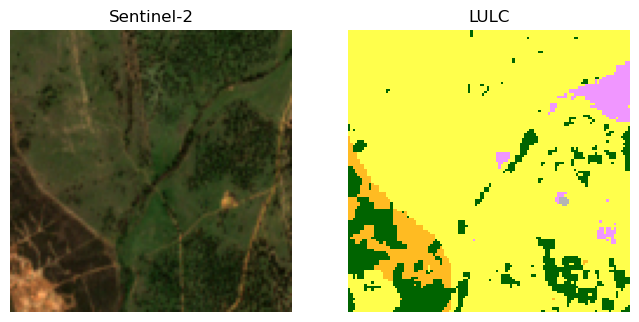

In [255]:
train_data.display(0)

For Neural Network training we have to define data loaders. When we do so, we have to define the batch size, which is typically limited by the GPU RAM during training. For evaluation purposes, we can typically pick a larger batch size, since we need less memory.

In [256]:
train_batchsize = 8
eval_batchsize = 16

train_dataloader = DataLoader(train_data, batch_size=train_batchsize, num_workers=4, pin_memory=True)
val_dataloader = DataLoader(val_data, batch_size=eval_batchsize, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=eval_batchsize, num_workers=4, pin_memory=True)

<a id='model'></a>
## 4. Model Implementation

In this notebook, we build a very simple 3-layer MLP to learn the task of classification. 

The model architecture will look as follows:
* As **input layer** we use a linear layer with 4 inputs (4 Sentinel-2 bands) and 50 outputs,
* the **hidden layer** has 50 inputs and 30 outputs, and
* the **output layer** has 30 inputs and 11 outputs (11 different lulc classes).

The input and hidden layers will use ReLU activation function and the output layer will be followed by a softmax function.

The network architecture is deliberately kept very small to enable fast training (even if you don't have a GPU at hand). Naturally, larger networks would result in better predictions.

We build the network architecture using PyTorch:

In [271]:
class BENGENet(nn.Module):
    
    # class constructor: here we define all the "building blocks" of our network
    def __init__(self):
        super(BENGENet, self).__init__()
        
        # input layer: layer 1 - in 4, out 50
        self.linear1 = nn.Linear(4, 50, bias=True)
        
        # hidden layer: layer 2 - in 50, out 30
        self.linear2 = nn.Linear(50, 30, bias=True)
        
        # output layer: layer 3 - in 30, out 11
        self.linear3 = nn.Linear(30, 11)

        self.logsoftmax = nn.LogSoftmax(dim=1)
        self.relu = nn.ReLU(inplace=True)

    # forward pass
    def forward(self, x):

        # reshape Sentinel-2 image to list of pixels
        x = torch.movedim(x.float(), 1, 3).reshape(-1, 4)

        # we send the reshaped input through the invidiual layers 
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.logsoftmax(self.linear3(x))
        
        return x

Now we instantiate the model and we're ready for training.

In [265]:
model = BENGENet()

<a id='train-val'></a>
## 5. Training and Validation

First of all, let's verify if a GPU is available on our compute machine. If not, the CPU will be used instead.

In [266]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Device used: {}'.format(device))

Device used: cpu


Before we can implement the training pipeline we have to define two more things: a Loss function and an optimizer that will update our model weights during training. We also define our evaluation metric, for which we use the accuracy score.

In [267]:
# we will use the cross entropy loss
loss = nn.NLLLoss()

# we will use the Adam optimizer
learning_rate = 0.001
opt = optim.Adam(params=model.parameters(), lr=learning_rate)

# we instantiate the accuracy metric
accuracy = Accuracy(task="multiclass", num_classes=11)

Now, we have to move the model and the loss function on the GPU, since the computationally heavy work will be conducted there.

In [268]:
model.to(device)
loss.to(device)
accuracy.to(device)

MulticlassAccuracy()

Finally, we can implement our training pipeline.


In [269]:
epochs = 30  # training for 30 epochs

train_losses_epochs = []
val_losses_epochs = []
train_accs_epochs = []
val_accs_epochs = []

for ep in range(epochs):

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    # we perform training for one epoch
    model.train()   # it is very important to put your model into training mode!
    for samples in tqdm(train_dataloader):
        # we extract the input data (Sentinel-2)
        x = samples['s2'].to(device)

        # now we extract the target (lulc class) and move it to the gpu
        y = samples['lulc'].view(-1).to(device)

        # we make a prediction with our model
        output = model(x)

        # we reset the graph gradients
        model.zero_grad()

        # we determine the classification loss
        loss_train = loss(output, y)

        # we run a backward pass to comput the gradients
        loss_train.backward()

        # we update the network paramaters
        opt.step()

        # we write the mini-batch loss and accuracy into the corresponding lists
        train_losses.append(loss_train.detach().cpu())
        train_accs.append(accuracy(torch.argmax(output, dim=1), y).detach().cpu())

    #print(train_accs)
    #print(output)

    # we evaluate the current state of the model on the validation dataset
    model.eval()   # it is very important to put your model into evaluation mode!
    with torch.no_grad():
        for samples in tqdm(val_dataloader):
            # we extract the input data (Sentinel-2)
            x = samples['s2'].to(device)

            # now we extract the target (lulc class) and move it to the gpu
            y = samples['lulc'].view(-1).to(device)

            # we make a prediction with our model
            output = model(x)

            # we determine the classification loss
            loss_val = loss(output, y)

            # we write the mini-batch loss and accuracy into the corresponding lists
            val_losses.append(loss_val.detach().cpu())
            val_accs.append(accuracy(torch.argmax(output, dim=1), y).detach().cpu())

    train_losses_epochs.append(np.mean(train_losses))
    train_accs_epochs.append(np.mean(train_accs))
    val_losses_epochs.append(np.mean(val_losses))
    val_accs_epochs.append(np.mean(val_accs))

    print("epoch {}: train: loss={}, acc={}; val: loss={}, acc={}".format(
        ep, train_losses_epochs[-1], train_accs_epochs[-1], 
        val_losses_epochs[-1], val_accs_epochs[-1]))

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 0: train: loss=2.277087450027466, acc=0.2141680121421814; val: loss=2.0077247619628906, acc=0.2656673789024353


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 1: train: loss=1.8384978771209717, acc=0.3235574960708618; val: loss=1.7997379302978516, acc=0.33060911297798157


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 2: train: loss=1.7524725198745728, acc=0.3278008997440338; val: loss=1.7744430303573608, acc=0.327679842710495


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 3: train: loss=1.7255780696868896, acc=0.32726287841796875; val: loss=1.7585210800170898, acc=0.32080787420272827


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 4: train: loss=1.7046926021575928, acc=0.3237221837043762; val: loss=1.743752121925354, acc=0.31753355264663696


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 5: train: loss=1.681328296661377, acc=0.32414060831069946; val: loss=1.7234535217285156, acc=0.31540727615356445


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 6: train: loss=1.6469393968582153, acc=0.3311949074268341; val: loss=1.688089370727539, acc=0.31521037220954895


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 7: train: loss=1.603352427482605, acc=0.3676297068595886; val: loss=1.6441848278045654, acc=0.4381590485572815


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 8: train: loss=1.55587899684906, acc=0.4674510955810547; val: loss=1.597410798072815, acc=0.44043588638305664


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 9: train: loss=1.5107060670852661, acc=0.47544920444488525; val: loss=1.5539536476135254, acc=0.4330568313598633


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 10: train: loss=1.472438931465149, acc=0.4761080741882324; val: loss=1.5172600746154785, acc=0.43002820014953613


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 11: train: loss=1.4423248767852783, acc=0.4727690815925598; val: loss=1.4898674488067627, acc=0.42852258682250977


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 12: train: loss=1.4196715354919434, acc=0.4727376103401184; val: loss=1.468022108078003, acc=0.4290633797645569


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 13: train: loss=1.4027117490768433, acc=0.4735454320907593; val: loss=1.450629711151123, acc=0.42991894483566284


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 14: train: loss=1.3895927667617798, acc=0.4744076728820801; val: loss=1.4368793964385986, acc=0.43079298734664917


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 15: train: loss=1.3789334297180176, acc=0.4760478436946869; val: loss=1.4250227212905884, acc=0.43223780393600464


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 16: train: loss=1.369850754737854, acc=0.47812333703041077; val: loss=1.4150269031524658, acc=0.43414726853370667


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 17: train: loss=1.3618437051773071, acc=0.4809117019176483; val: loss=1.4054362773895264, acc=0.43898454308509827


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 18: train: loss=1.3543822765350342, acc=0.4838728904724121; val: loss=1.3974521160125732, acc=0.44018083810806274


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 19: train: loss=1.3474513292312622, acc=0.4868573546409607; val: loss=1.3906652927398682, acc=0.44200649857521057


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 20: train: loss=1.3410478830337524, acc=0.489760160446167; val: loss=1.3842549324035645, acc=0.4510415196418762


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 21: train: loss=1.334815502166748, acc=0.49246087670326233; val: loss=1.3779408931732178, acc=0.45368385314941406


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 22: train: loss=1.3287944793701172, acc=0.49530795216560364; val: loss=1.3712270259857178, acc=0.4565160870552063


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 23: train: loss=1.322816252708435, acc=0.49799036979675293; val: loss=1.3648921251296997, acc=0.45938602089881897


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 24: train: loss=1.3168896436691284, acc=0.5005523562431335; val: loss=1.3587005138397217, acc=0.46228617429733276


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 25: train: loss=1.3110088109970093, acc=0.5031701922416687; val: loss=1.3524479866027832, acc=0.4649040699005127


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 26: train: loss=1.3051462173461914, acc=0.5055516958236694; val: loss=1.346279501914978, acc=0.46715641021728516


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 27: train: loss=1.2993367910385132, acc=0.507731020450592; val: loss=1.340206265449524, acc=0.46882015466690063


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 28: train: loss=1.2935973405838013, acc=0.5097736120223999; val: loss=1.3342453241348267, acc=0.4704440236091614


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 29: train: loss=1.2879633903503418, acc=0.5117497444152832; val: loss=1.3284045457839966, acc=0.4721005856990814


Training progress looks good: train and validation losses are decreasing, accuracies are increasing.

Let's plot the available metrics as a function of the number of training iterations:

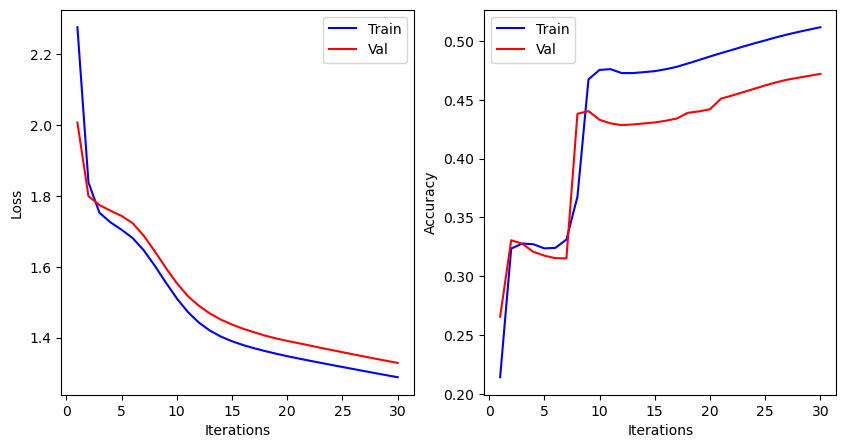

In [270]:
f, ax = plt.subplots(1, 2, sharex=True, figsize=(10,5))

ax[0].plot(np.arange(1, len(train_losses_epochs)+1), train_losses_epochs, label='Train', color='blue')
ax[0].plot(np.arange(1, len(val_losses_epochs)+1), val_losses_epochs, label='Val', color='red')
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(np.arange(1, len(train_accs_epochs)+1), train_accs_epochs, label='Train', color='blue')
ax[1].plot(np.arange(1, len(val_accs_epochs)+1), val_accs_epochs, label='Val', color='red')
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

We see how the losses drop and the accuracy increases for both the training and validation dataset. Since the validation metrics follow the training metrics, we do not see any obvious signs for overfitting. Based on the validation dataset, we reach an accuracy of 47% for our multi-class classification problem.

<a id='hyperpars'></a>
## 6. Hyperparameter Tuning

We trained the model successfully. But did we manage to get the best possible result?

In order to find out, we have to perform hyperparameter tuning. The only obvious hyperparameter of our model is the learning rate. Architectural considerations can also be considered as hyperparameters, but we will keep our architecture fixed.

As a result, we only have to tune the learning rate. We could try other learning rate values, such as 0.01 or 0.0001, or use a scheduler that modifies the learning rate as a function of the training progress.

However, we will skip this tuning process here to save some time. Instead, we will use the trained model "as is".



<a id='evaluation'></a>
## 7. Evaluation

After finishing the hyperparameter tuning, we can perform the final evaluation of our model. We will again use the accuracy metric, but could easily replace it or add additional metrics.

To properly evaluate our model we must use the test dataset in the evaluation process. Since the model has never seen the test dataset before, it will provide a realistic estimate of the performance of the model on previously unseen data.

The evaluation uses more or less the same code that we used to evaluate our model during training:

In [272]:
test_accs = []
predictions = []
groundtruths = []

model.eval()   # it is very important to put your model into evaluation mode!
with torch.no_grad():
    for samples in tqdm(test_dataloader):
        x = samples['s2']

        # now we extract the target (lulc class) and move it to the gpu
        y = samples['lulc'].view(-1)
        groundtruths.append(y.cpu())

        # we make a prediction with our model
        output = model(x)

        predictions.append(np.argmax(output.cpu().numpy(), axis=1))

        # we determine the classification loss
        loss_val = loss(output, y)

        # we write the mini-nbatch loss and accuracy into the corresponding lists
        test_accs.append(accuracy(torch.argmax(output, dim=1), y).cpu().numpy())

print('test dataset accuracy:', np.mean(test_accs))

# flatten predictions and groundtruths
predictions = np.concatenate(predictions).ravel()
groundtruths = np.concatenate(groundtruths).ravel()


  0%|          | 0/10 [00:00<?, ?it/s]

test dataset accuracy: 0.49772358


The test dataset accuracy is 50%, which is even higher than the validation accuracy.

**Question**: Don't get fooled by the accuracy. The model performs not too badly. What is the baseline accuracy you would expect for for random guessing in a multi-class classification problem, if there are 11 different classes?

Now, let's also have a look at the performance on a per-class basis via the confusion matrix:

In [276]:
ewc_label_names

['tree_cover',
 'shrubland',
 'grassland',
 'cropland',
 'built-up',
 'bare/sparse_vegetation',
 'snow_and_ice',
 'permanent_water_bodies',
 'herbaceous_wetland',
 'mangroves',
 'moss_and_lichen']

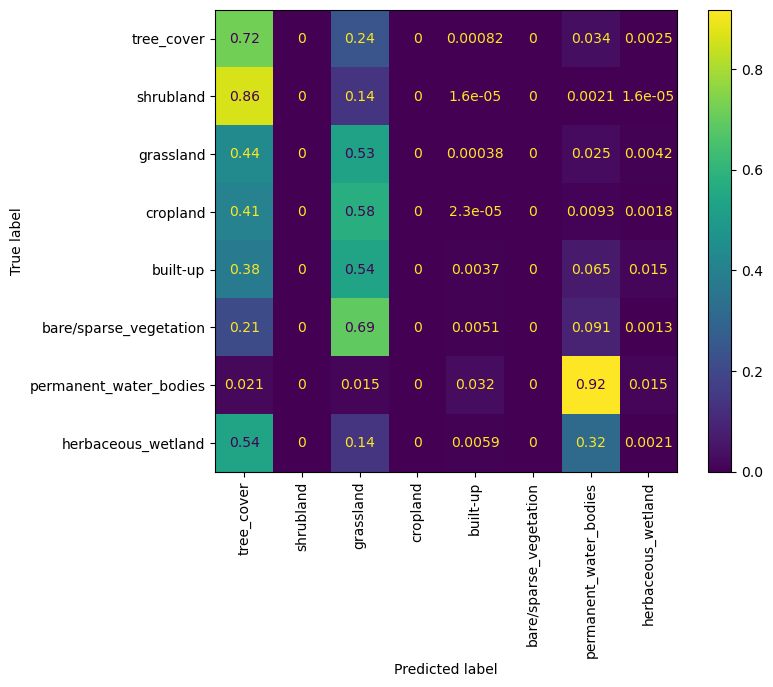

In [298]:
f, ax = plt.subplots(1, 1, figsize=(8,6))

# plot the confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(
    groundtruths, predictions,
    display_labels=[ewc_label_names[i] for i in np.unique(groundtruths)],
    normalize='true',
    ax=ax)
# note that not all classes are present in the test dataset

# rotate x labels for better readability
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)

The confusion matrix reveals a few limitations of our trained model:
* the model is unable to predict some of the classes (e.g., shrubland, cropland and bare/sparse vegeation; and it is bad at predicting built-up areas)
* the model is very good at identifying water surfaces
* there is significant confusion between a number of classes (e.g., a variety of classes are confused with tree cover and grassland)

**Question**: What are the reasons for these limitations?

<a id='inference'></a>
## 8. Inference

Now that our model is trained and evaluated, we can use it to predict the most common land-use/land-cover class in an image patch.

Let's pick a random patch from our test dataset and run it through the model to perfom a prediction:

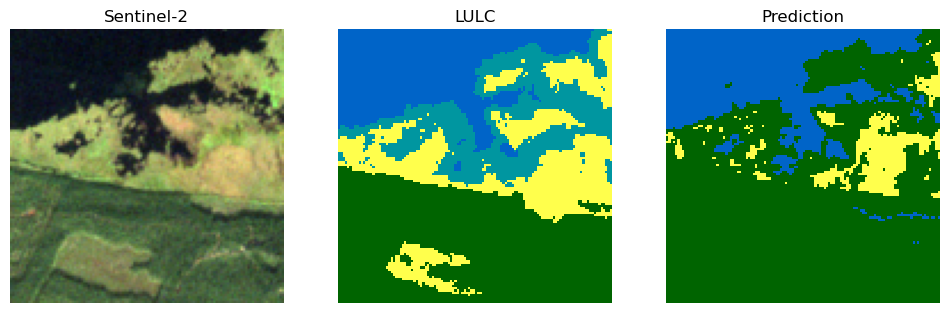

In [299]:
i = 42

# we retrieve a random sample
sample = test_data[i]

input = sample['s2']
output = model(input.view(1, 4, 120, 120).to(device))  # we have to change the shape of the input
prediction = torch.argmax(output, dim=1).reshape(120, 120)

# display prediction
test_data.display(i, pred=prediction)

The model gets the overall shapes right, but it fails to get the right classes in many cases.